# Rankine_Vortex_Model_Example
- Author: Hamid Ali Syed

⚠️ **Proceed with caution: The results may contain errors and are based on idealized assumptions.**

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

In [2]:
def gradient_wind_balance(f, dp_dr, r, rho_0):
    """
    Compute the gradient wind balance using the Coriolis force and pressure gradient force.
    
    Parameters
    ----------
    f : float or xarray.DataArray
        Coriolis parameter (s^-1).
    dp_dr : float or xarray.DataArray
        Radial pressure gradient (Pa/m).
    r : float or xarray.DataArray
        Distance from the tropical cyclone center (m).
    rho_0 : float or xarray.DataArray
        Air density (kg/m^3).
    
    Returns
    -------
    v : float or xarray.DataArray
        Rotational wind speed (m/s).
    """
    v_squared = (1 / rho_0) * dp_dr * r + (f * r)**2 / 4
    v = np.sqrt(v_squared)
    return v

def solve_max_wind(p_min, p_sl, rho_0, f, R):
    """
    Solve the quadratic equation for the maximum rotational wind speed in a tropical cyclone.
    
    V^2 + f*R(1/2 + ln(10))*V + (p_min - p_sl)/rho_0 = 0
    
    Parameters
    ----------
    p_min : float
        Minimum central pressure (Pa).
    p_sl : float
        Base state pressure at sea level (Pa).
    rho_0 : float
        Air density (kg/m^3).
    f : float
        Coriolis parameter (s^-1).
    R : float
        Radius of maximum wind (m).
    
    Returns
    -------
    V : float
        Maximum rotational wind speed (m/s).
    """
    # Define the quadratic coefficients
    a = 1
    b = f * R * (1/2 + np.log(10))
    c = (p_min - p_sl) / rho_0
    
    # Solve quadratic equation using scipy's root_scalar
    def quadratic(v):
        return a * v**2 + b * v + c

    sol = root_scalar(quadratic, bracket=[0, 100], method='bisect')
    return sol.root

def outer_vortex_wind(p_sl, p_r, rho_0, f, R, r):
    """
    Compute the rotational wind speed in the outer vortex region of a tropical cyclone.

    Parameters
    ----------
    p_sl : float
        Base state pressure at sea level (Pa).
    p_r : float
        Pressure at radius r (Pa).
    rho_0 : float
        Air density (kg/m^3).
    f : float
        Coriolis parameter (s^-1).
    R : float
        Radius of maximum wind (m).
    r : float
        Distance from tropical cyclone center (m).
    
    Returns
    -------
    v : float
        Rotational wind speed (m/s).
    """
    term1 = (1 / rho_0) * (p_sl - p_r)
    term2 = f * R * np.log(10)
    v_squared = term1 + term2
    v = np.sqrt(v_squared)
    return v

def inner_vortex_wind(p_r, p_min, rho_0, R, r):
    """
    Compute the rotational wind speed in the inner vortex region of a tropical cyclone.
    
    Parameters
    ----------
    p_r : float
        Pressure at radius r (Pa).
    p_min : float
        Minimum central pressure (Pa).
    rho_0 : float
        Air density (kg/m^3).
    R : float
        Radius of maximum wind (m).
    r : float
        Distance from tropical cyclone center (m).
    
    Returns
    -------
    v : float
        Rotational wind speed (m/s).
    """
    term1 = (1 / rho_0) * (p_r - p_min)
    v_squared = term1 * (R / r)**2
    v = np.sqrt(v_squared)
    return v

def rankine_vortex_wind_field(r, R, V_max):
    """
    Approximate the tropical cyclone wind field as a Rankine vortex.

    Parameters
    ----------
    r : float or xarray.DataArray
        Distance from tropical cyclone center (m).
    R : float
        Radius of maximum wind (m).
    V_max : float
        Maximum rotational wind speed (m/s).
    
    Returns
    -------
    v : float or xarray.DataArray
        Rotational wind speed (m/s).
    """
    v = xr.where(r <= R, V_max * (r / R), V_max * (R / r))
    return v

In [3]:
def plot_rankine_vortex_wind_field(r, v):
    """
    Plot the wind field from the Rankine vortex model in knots.

    Parameters
    ----------
    r : xarray.DataArray
        Radial distance from the tropical cyclone center (km).
    v : xarray.DataArray
        Wind speed (knots).
    """
    plt.figure(figsize=(8, 6))

    # Plot the wind speed as a function of radial distance
    plt.plot(r / 1000, v, color='b', lw=2, label='Wind Speed (knots)')

    # Add titles and labels with units
    plt.title("Tropical Cyclone Wind Profile (Rankine Vortex)", fontsize=14)
    plt.xlabel("Radial Distance from Center (km)", fontsize=12)
    plt.ylabel("Wind Speed (knots)", fontsize=12)
    
    # Add gridlines and style
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right')
    
    # Customize ticks
    plt.xticks(np.arange(0, np.max(r) / 1000 + 10, step=10))
    plt.yticks(np.arange(0, np.max(v) + 10, step=10))
    
    # Improve the layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

def convert_to_knots(v_mps):
    """
    Convert wind speed from meters per second (m/s) to knots.

    Parameters
    ----------
    v_mps : float or xarray.DataArray
        Wind speed in meters per second (m/s).
    
    Returns
    -------
    v_knots : float or xarray.DataArray
        Wind speed in knots.
    """
    return v_mps / 0.51444  # Convert m/s to knots

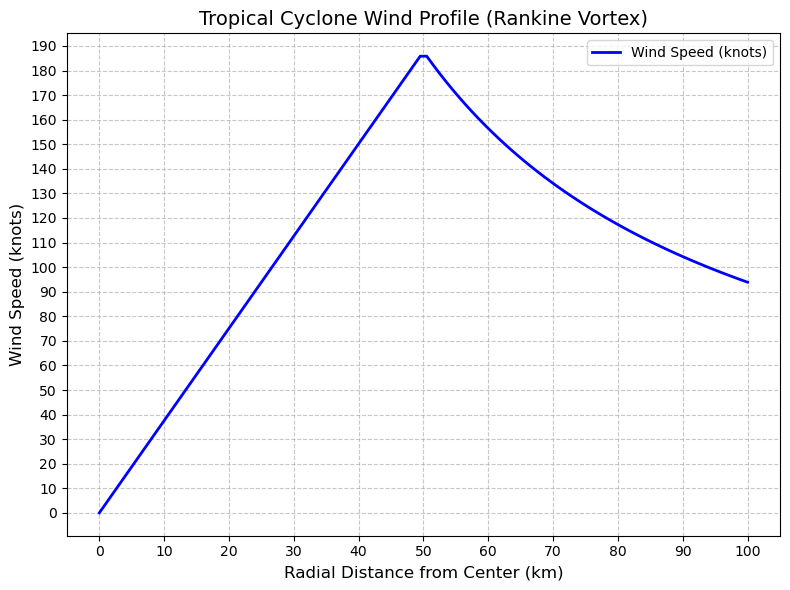

In [4]:
# Example parameters based on realistic tropical cyclone conditions in the tropics
p_min = 90000  # Pa (typical minimum central pressure in a strong cyclone)
p_sl = 101300  # Pa (sea level pressure)
rho_0 = 1.15   # kg/m^3 (air density)
f = 3.7e-5     # s^-1 (Coriolis parameter at around 15° latitude)
R = 50000      # m (50 km, radius of maximum wind)

# Solve for max wind speed in m/s
V_max_mps = solve_max_wind(p_min, p_sl, rho_0, f, R)

# Convert max wind speed to knots
V_max_knots = convert_to_knots(V_max_mps)

# Create an array of radial distances (in meters)
r = xr.DataArray(np.linspace(0, 100000, 100), dims=["r"], name="radial_distance")

# Compute the wind field in m/s using the Rankine vortex model
v_mps = rankine_vortex_wind_field(r, R, V_max_mps)

# Convert wind speed to knots
v_knots = convert_to_knots(v_mps)

# Plot the wind field in knots
plot_rankine_vortex_wind_field(r, v_knots)

In [5]:
def pressure_profile(p_sl, p_min, r, R, V_max, rho_0):
    """
    Calculate the pressure profile of a tropical cyclone using the Rankine vortex model.
    
    Parameters
    ----------
    p_sl : float
        Sea level pressure (Pa).
    p_min : float
        Minimum central pressure (Pa).
    r : xarray.DataArray
        Radial distance from the tropical cyclone center (m).
    R : float
        Radius of maximum wind (m).
    V_max : float
        Maximum wind speed (m/s).
    rho_0 : float
        Air density (kg/m^3).
    
    Returns
    -------
    pressure : xarray.DataArray
        Pressure at each radial distance from the center (Pa).
    """
    # Set a minimum threshold for r to avoid log(0) errors
    r_safe = xr.where(r <= 1, 1, r)  # Set a minimum value of 1 meter for r
    
    # Define pressure inside and outside the radius of maximum wind
    p_r = xr.where(
        r_safe <= R,
        p_min + (rho_0 * (V_max**2) * (r_safe**2 / R**2) / 2),  # Inner vortex
        p_min + (rho_0 * (V_max**2) / 2) - rho_0 * V_max**2 * np.log(r_safe / R)  # Outer vortex, corrected
    )
    
    # Ensure that pressure doesn't drop below p_min
    p_r = xr.where(p_r < p_min, p_min, p_r)

    return p_r

def centrifugal_force(r, v):
    """
    Calculate the centrifugal force acting on an air parcel in a tropical cyclone.
    
    Parameters
    ----------
    r : xarray.DataArray
        Radial distance from the tropical cyclone center (m).
    v : xarray.DataArray
        Wind speed at each radial distance (m/s).
    
    Returns
    -------
    f_cent : xarray.DataArray
        Centrifugal force per unit mass (m/s^2).
    """
    return v**2 / r

def coriolis_force(f, v):
    """
    Calculate the Coriolis force acting on an air parcel in a tropical cyclone.
    
    Parameters
    ----------
    f : float
        Coriolis parameter (s^-1).
    v : xarray.DataArray
        Wind speed at each radial distance (m/s).
    
    Returns
    -------
    f_cor : xarray.DataArray
        Coriolis force per unit mass (m/s^2).
    """
    return f * v

def plot_pressure_profile(r, p_r):
    """
    Plot the pressure profile of a tropical cyclone in hPa.
    
    Parameters
    ----------
    r : xarray.DataArray
        Radial distance from the tropical cyclone center (m).
    p_r : xarray.DataArray
        Pressure at each radial distance (Pa), converted to hPa in the plot.
    """
    # Convert pressure from Pa to hPa
    p_r_hpa = p_r / 100  # 1 hPa = 100 Pa
    
    plt.figure(figsize=(8, 6))
    
    # Plot pressure profile
    plt.plot(r / 1000, p_r_hpa, color='r', lw=2, label='Pressure (hPa)')
    
    # Add titles and labels
    plt.title("Tropical Cyclone Pressure Profile", fontsize=14)
    plt.xlabel("Radial Distance from Center (km)", fontsize=12)
    plt.ylabel("Pressure (hPa)", fontsize=12)
    
    # Add grid for better visibility
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right')
    
    # Layout for better spacing
    plt.tight_layout()
    
    # Show the plot
    plt.show()

def plot_forces(r, f_cent, f_cor):
    """
    Plot the centrifugal and Coriolis forces acting in the cyclone with separate axes and legends.

    Parameters
    ----------
    r : xarray.DataArray
        Radial distance from the tropical cyclone center (km).
    f_cent : xarray.DataArray
        Centrifugal force (m/s^2).
    f_cor : xarray.DataArray
        Coriolis force (m/s^2).
    """
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot centrifugal force on ax1 (left y-axis)
    ax1.plot(r / 1000, f_cent, color='g', lw=2, label='Centrifugal Force (m/s^2)')
    ax1.set_xlabel("Radial Distance from Center (km)", fontsize=12)
    ax1.set_ylabel("Centrifugal Force (m/s^2)", color='g', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='g')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Create a second y-axis for Coriolis force using twinx
    ax2 = ax1.twinx()
    ax2.plot(r / 1000, f_cor, color='b', lw=2, label='Coriolis Force (m/s^2)')
    ax2.set_ylabel("Coriolis Force (m/s^2)", color='b', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='b')

    # Title of the plot
    plt.title("Forces in a Tropical Cyclone", fontsize=14)

    # Place separate legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

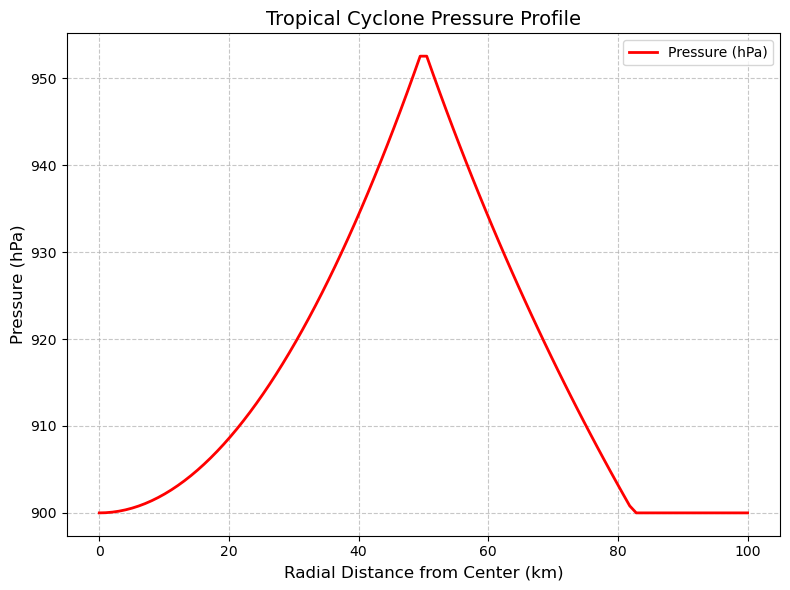

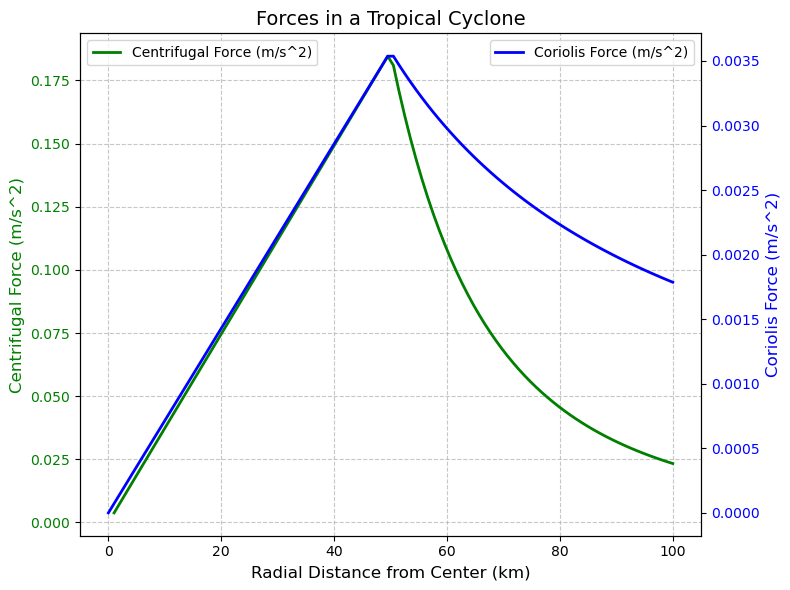

In [6]:
# Example parameters based on realistic tropical cyclone conditions in the tropics
p_min = 90000  # Pa (typical minimum central pressure in a strong cyclone)
p_sl = 101300  # Pa (sea level pressure)
rho_0 = 1.15   # kg/m^3 (air density)
f = 3.7e-5     # s^-1 (Coriolis parameter at around 15° latitude)
R = 50000      # m (50 km, radius of maximum wind)

# Solve for max wind speed in m/s
V_max_mps = solve_max_wind(p_min, p_sl, rho_0, f, R)

# Create an array of radial distances (in meters)
r = xr.DataArray(np.linspace(0, 100000, 100), dims=["r"], name="radial_distance")

# Compute the wind field in m/s using the Rankine vortex model
v_mps = rankine_vortex_wind_field(r, R, V_max_mps)

# Convert wind speed to knots
v_knots = convert_to_knots(v_mps)

# Compute the pressure profile (in Pa)
p_r = pressure_profile(p_sl, p_min, r, R, V_max_mps, rho_0)

# Plot the pressure profile (converted to hPa for better readability)
plot_pressure_profile(r, p_r)

# Compute the centrifugal and Coriolis forces
f_cent = centrifugal_force(r, v_mps)
f_cor = coriolis_force(f, v_mps)

# Plot the centrifugal and Coriolis forces
plot_forces(r, f_cent, f_cor)

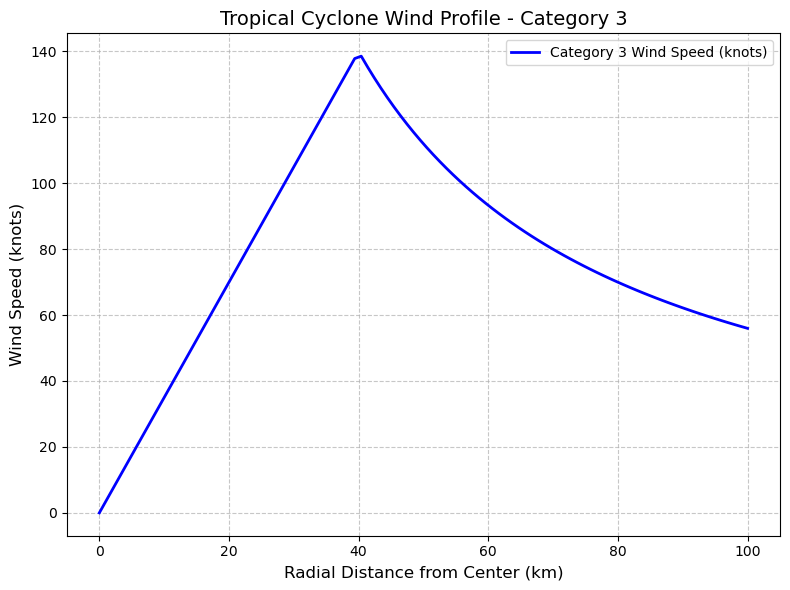

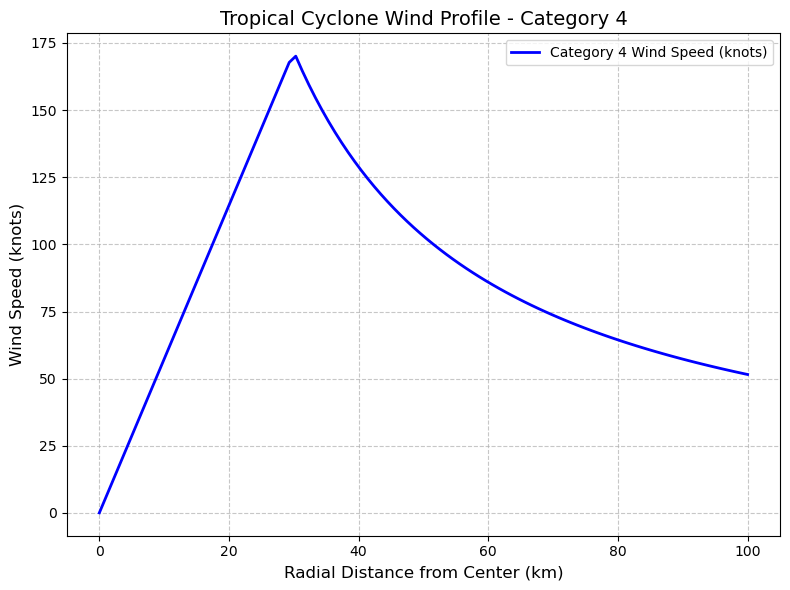

In [7]:
# Function to simulate and plot hurricane wind profile for a given category
def simulate_hurricane(p_min, p_sl, R, category):
    """
    Simulate and plot wind profile for a given hurricane category using the Rankine vortex model.
    
    Parameters
    ----------
    p_min : float
        Minimum central pressure (Pa).
    p_sl : float
        Sea level pressure (Pa).
    R : float
        Radius of maximum wind (m).
    category : str
        The category of the hurricane (e.g., "Category 3", "Category 4").
    """
    # Constants
    rho_0 = 1.15   # kg/m^3 (air density)
    f = 3.7e-5     # s^-1 (Coriolis parameter at around 15° latitude)

    # Solve for max wind speed in m/s
    V_max_mps = solve_max_wind(p_min, p_sl, rho_0, f, R)

    # Convert max wind speed to knots
    V_max_knots = convert_to_knots(V_max_mps)

    # Create an array of radial distances (in meters)
    r = xr.DataArray(np.linspace(0, 100000, 100), dims=["r"], name="radial_distance")

    # Compute the wind field using the Rankine vortex model
    v_mps = rankine_vortex_wind_field(r, R, V_max_mps)

    # Convert wind speed to knots
    v_knots = convert_to_knots(v_mps)

    # Plot the wind field
    plt.figure(figsize=(8, 6))
    plt.plot(r / 1000, v_knots, color='b', lw=2, label=f'{category} Wind Speed (knots)')
    plt.title(f"Tropical Cyclone Wind Profile - {category}", fontsize=14)
    plt.xlabel("Radial Distance from Center (km)", fontsize=12)
    plt.ylabel("Wind Speed (knots)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Example for Category 3 hurricane
simulate_hurricane(p_min=95000, p_sl=101300, R=40000, category="Category 3")

# Example for Category 4 hurricane
simulate_hurricane(p_min=92000, p_sl=101300, R=30000, category="Category 4")

### Summary

This Jupyter notebook simulates and analyzes the wind speed profiles of tropical cyclones (hurricanes) using the **Rankine vortex model**, a well-established approximation for cyclone wind fields. The primary objective is to compute wind speed distributions based on central pressure, radius of maximum wind, and other storm characteristics, enabling us to categorize hurricanes according to the **Saffir-Simpson Hurricane Wind Scale**.

#### Key Components:
1. **Rankine Vortex Model**: 
   - This model divides the tropical cyclone into two regions: an inner region where the wind speed increases linearly with radial distance, and an outer region where wind speed decreases following an inverse relationship with radial distance. The radius of maximum wind (R) defines the boundary between these regions.
   
2. **Wind Speed Calculations**:
   - We calculate the maximum wind speed (\(V_{\text{max}}\)) using inputs such as central pressure (\(p_{\text{min}}\)), sea level pressure (\(p_{\text{sl}}\)), air density (\(\rho_0\)), and the Coriolis parameter (\(f\)).
   - The wind speed is then computed as a function of radial distance from the storm's center, both in **meters per second (m/s)** and **knots**.

3. **Pressure Profile**:
   - The pressure profile is also calculated based on the pressure gradient and distance from the center. This helps visualize how pressure decreases as you approach the storm's core.

4. **Forces Acting on the Storm**:
   - **Centrifugal force** and **Coriolis force** are computed to show the dynamic balance within the storm. These forces vary with radial distance and wind speed.

#### Usage of the Code:
- The code can be used to model and visualize the wind fields of tropical cyclones of various intensities, based on input parameters such as central pressure, sea level pressure, and radius of maximum wind.
- It can simulate different categories of hurricanes (e.g., Category 3, Category 4, Category 5) based on the **Saffir-Simpson Hurricane Wind Scale**.
- It enables meteorologists, students, and researchers to better understand the wind structure and dynamics of hurricanes, providing insights into the storm's potential impact.

#### Assumptions:
1. **Rankine Vortex Model**:
   - The storm's wind field is assumed to follow a Rankine vortex structure, which provides an idealized but effective representation of the wind profile for tropical cyclones.
   
2. **Air Density (\(\rho_0\))**:
   - A constant air density of 1.15 kg/m³ is used, typical of tropical cyclone conditions.
   
3. **Coriolis Parameter (\(f\))**:
   - A Coriolis parameter of \(3.7 \times 10^{-5} \, \text{s}^{-1}\) is assumed, corresponding to latitudes around 15°.

4. **Pressure and Radius of Maximum Wind**:
   - The central pressure, sea level pressure, and radius of maximum wind are key inputs that drive the wind speed calculations. Adjusting these parameters allows for simulating different storm intensities.

#### Expectations:
- **Wind Speed Profiles**: The wind speed will increase from the storm's center, reaching a maximum at the radius of maximum wind (R), and then gradually decrease as you move further from the center.
- **Pressure Profile**: The pressure will decrease from sea level pressure at the storm's outer regions toward the minimum central pressure at the core.
- **Force Balance**: The centrifugal and Coriolis forces will peak near the radius of maximum wind, providing insights into the storm's dynamics.